In [ ]:
!pip install scanpy
!pip install episcanpy

     |████████████████████████████████| 2.0 MB 5.0 MB/s 
     |████████████████████████████████| 80 kB 6.7 MB/s 
     |████████████████████████████████| 127 kB 26.9 MB/s 
     |████████████████████████████████| 1.1 MB 27.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=d575268377aaf292e1ee638b1589b4bcf76aadd28b8b9a246667a9fa93567f50
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=b4af6101fffc4c73fbf732bfcb521e70a8ee472bc77d6b30805d44a65cc41ede
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=b8e8bc368d3dfaa40fd97f9e9e2628d7e16f9f5a2719da858f88fe853c7a9890
  Stored in directory: /root/.cache/

In [ ]:
!pip install leidenalg

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy as epi
from scipy.sparse import issparse
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
##Baseline_Dataloader
raw_atac = sc.read_h5ad("drive/MyDrive/B2_Model/dataset/E18_mouse_brain/e18_mouse_brain_fresh_5k_atac_fragments.h5ad")
trans_atac_train = np.load("drive/MyDrive/output_0801_02/atac_trans_output_train.npy")
trans_atac_test = np.load("drive/MyDrive/output_0801_02/atac_trans_output_test.npy")
target_name_test = pd.read_table("drive/MyDrive/output_0801_02/atac_targets_test.txt",header=None)
target_name_train = pd.read_table("drive/MyDrive/output_0801_02/atac_targets_train.txt", header=None)

In [ ]:
def preprocessing_atac(
        adata, 
        min_genes=200, 
        min_cells=0.01, 
        n_top_genes=30000,
        target_sum=None
    ):
    """
    preprocessing
    """
    print('Raw dataset for scATAC shape: {}'.format(adata.shape))

    if not issparse(adata.X):
        adata.X = scipy.sparse.csr_matrix(adata.X)
    
    print(np.max(adata.X))    
    
    #binarize:
    #epi.pp.binarize(adata)
    
    #Filtering cells
    #sc.pp.filter_cells(adata, min_genes=min_genes)
    
    #'Filtering genes'
    if min_cells < 1:
        min_cells = min_cells * adata.shape[0]
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    #Finding variable features
    adata = epi.pp.select_var_feature(adata, nb_features=n_top_genes, show=False, copy=True)
    
    #Normalizing total per cell
    sc.pp.normalize_total(adata, target_sum=target_sum)
        

    print('Processed dataset shape: {}'.format(adata.shape))
    return adata

In [ ]:
def Downstream_analysis(raw_data):
  adata = preprocessing_atac(raw_data)
  #epi.pp.log1p(adata) #depend of the dataset
  epi.pp.lazy(adata)
  epi.tl.leiden(adata)
  epi.pl.umap(adata, color=['leiden'], wspace=0.4)
  epi.tl.rank_features(adata, 'leiden', omic='ATAC')
  epi.pl.rank_feat_groups(adata)
  return adata

In [ ]:
raw_adata = Downstream_analysis(raw_atac)

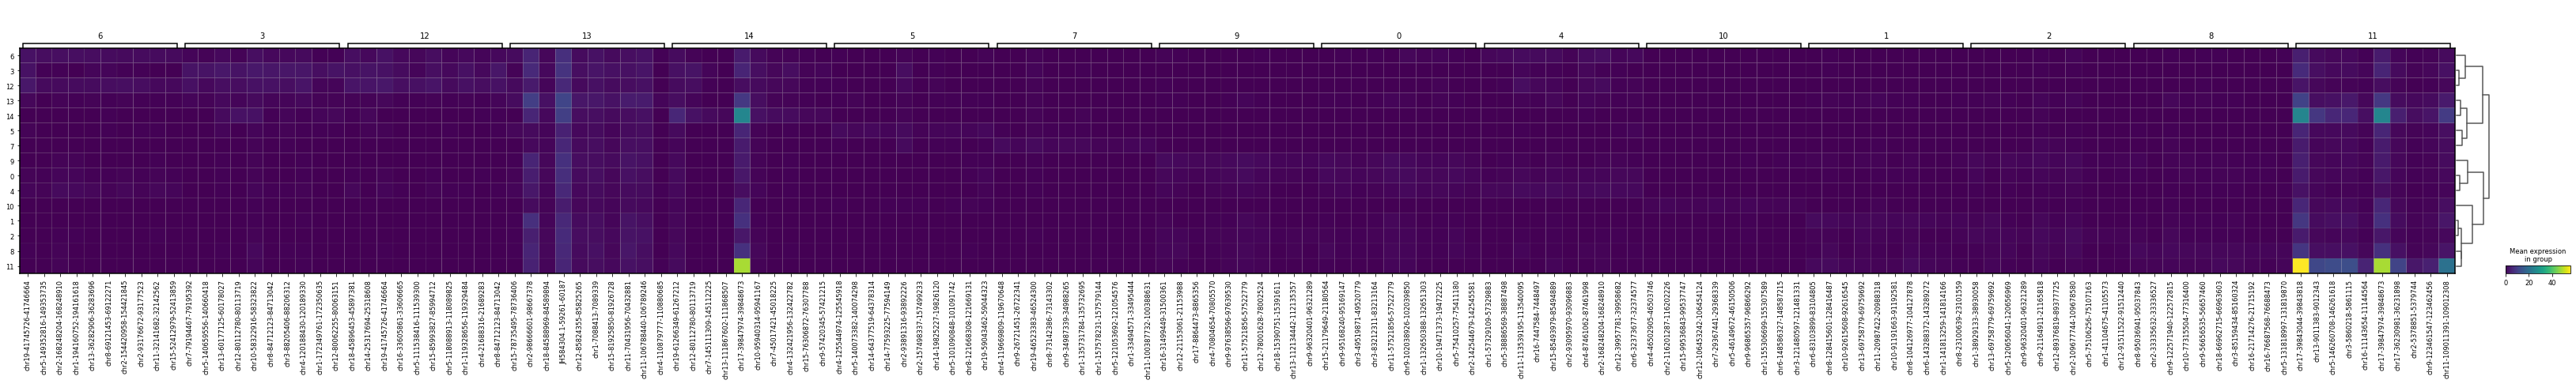

In [ ]:
epi.pl.rank_feat_groups_matrixplot(raw_adata)

In [ ]:
def train_test_merge_shuffle(train,test):
  pre_atac = preprocessing_atac(raw_atac)
  var_name = pre_atac.var_names
  cell_name_train = pd.Index(target_name_train)
  cell_name_test = pd.Index(target_name_test)
  train = pd.DataFrame(train, index = cell_name_train, columns=var_name)
  test = pd.DataFrame(test, index = cell_name_test, columns=var_name)
  trans_atac = train.append(test)
  adata = ad.AnnData(trans_atac, dtype = "int32")
  print(adata)
  return adata

In [ ]:
def train_test_merge(train,test):
  pre_atac = preprocessing_atac(raw_atac)
  var_name = pre_atac.var_names
  len_train = int(pre_atac.to_df().shape[0]*0.8)
  cell_name_train = pre_atac.obs_names[:len_train]
  cell_name_test = pre_atac.obs_names[len_train:]
  train = pd.DataFrame(train, index = cell_name_train, columns=var_name)
  test = pd.DataFrame(test, index = cell_name_test, columns=var_name)
  trans_atac = train.append(test)
  adata = ad.AnnData(trans_atac, dtype = "int32")
  print(adata)
  return adata

In [ ]:
def Downstream_analysis_trans(train, test):
  adata = train_test_merge_shuffle(train, test)
  #epi.pp.log1p(adata) #depend of the dataset
  epi.pp.lazy(adata)
  epi.tl.leiden(adata)
  epi.pl.umap(adata, color=['leiden'], wspace=0.4,use_raw=False)
  epi.tl.rank_features(adata, 'leiden', omic='ATAC',use_raw=False)
  epi.pl.rank_feat_groups(adata)
  return adata

Raw dataset for scATAC shape: (4482, 172193)
239.0


Processed dataset shape: (4482, 30002)
AnnData object with n_obs × n_vars = 4482 × 30002


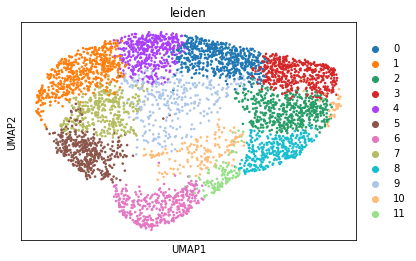

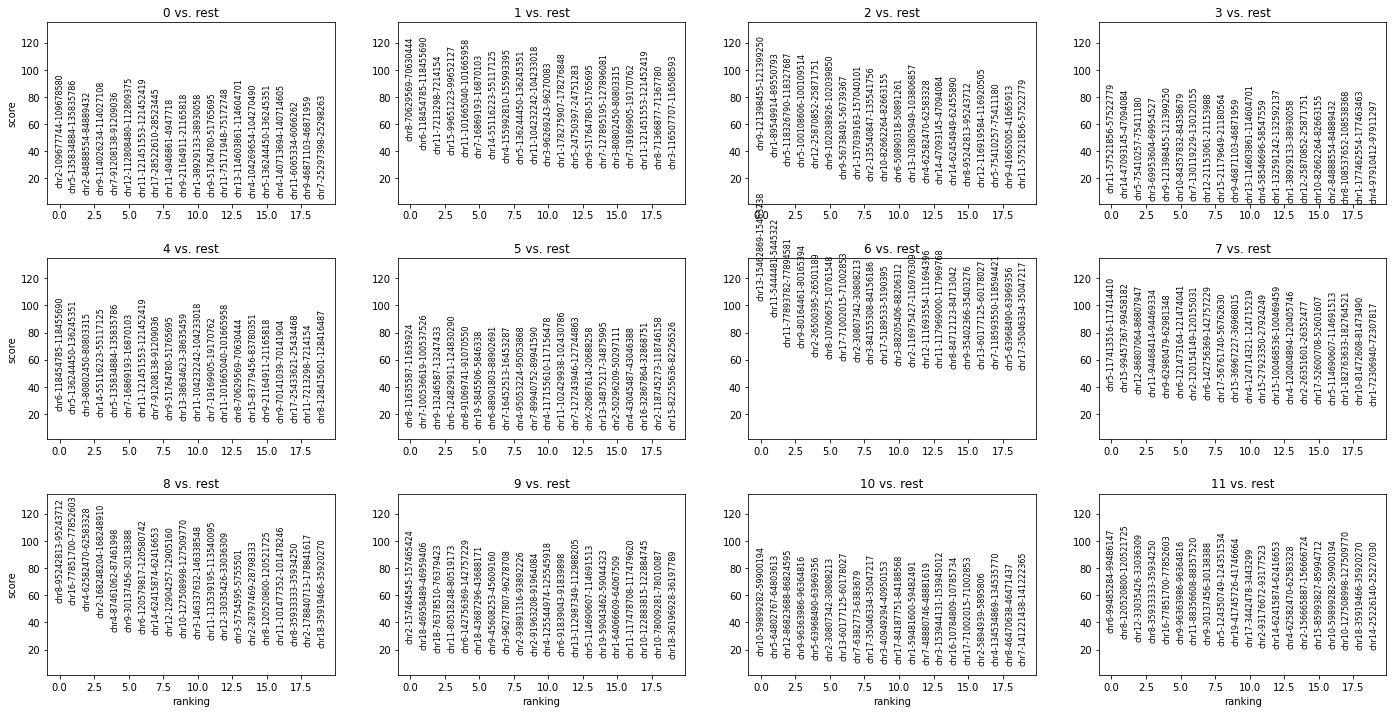

In [ ]:
predict_adata = Downstream_analysis_trans(trans_atac_train, trans_atac_test) 

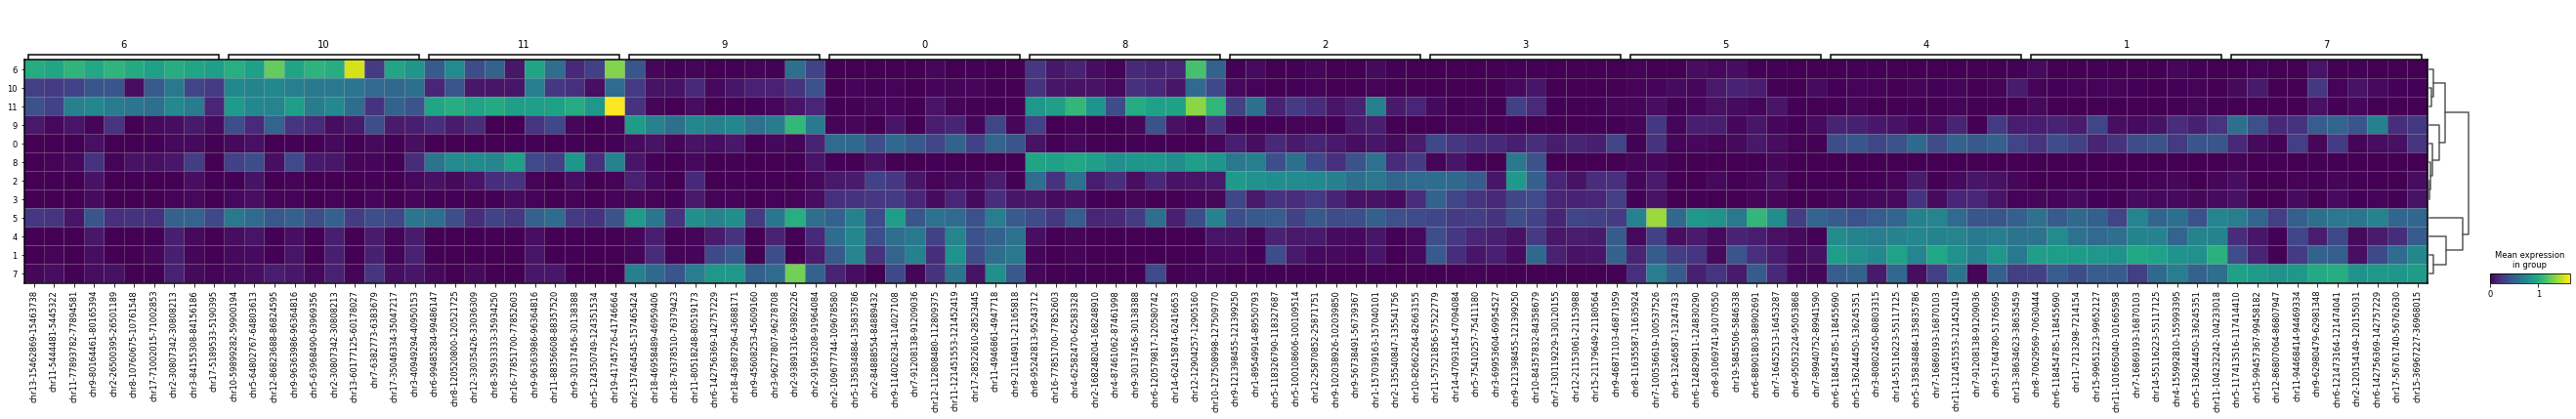

In [ ]:
epi.pl.rank_feat_groups_matrixplot(predict_adata)